<a href="https://colab.research.google.com/github/AdityaV3/ps2/blob/main/Classical_Time_Series_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving all_feature_data_avg.csv to all_feature_data_avg.csv


In [2]:
import pandas as pd
import numpy as np

file_name = 'all_feature_data_avg.csv'
data = pd.read_csv(file_name)
display(data.head())

,Unnamed: 0,year_index,index,id2,year,yield,tmmx,rmax,vs,sph,srad,vpd,rmin,pr,tmmn,th
0,0,0,1,112,1980,27.0,302.547299,88.534865,4.169133,0.010406,244.856055,1.477316,34.108888,2.150448,287.698991,182.028998
1,1,1,2,113,1980,28.0,302.068878,85.865079,3.564974,0.010097,243.893545,1.461499,34.400296,2.342725,287.706825,192.143968
2,2,2,3,119,1980,29.0,303.100471,91.763880,3.560391,0.011191,251.878185,1.429625,36.004177,2.067676,288.491839,178.083970
3,3,3,4,120,1980,28.0,302.966961,88.569844,3.964970,0.010669,250.073255,1.484913,35.960727,2.714061,288.009203,192.123030
4,4,4,5,124,1980,24.0,303.312180,89.555033,3.494477,0.011313,254.001956,1.481304,36.824029,2.435780,289.358179,176.449627


In [ ]:
# Aggregate 'yield' by year
yield_by_year = data.groupby(data.index)['yield'].sum().reset_index()

display(yield_by_year.head())

,index,yield
0,0,27.0
1,1,28.0
2,2,29.0
3,3,28.0
4,4,24.0


## Differenced VAR model

In [5]:
# Differenced VAR model with Leave-One-Year-Out cross-validation
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


var_variables = ['yield', 'tmmx', 'rmax', 'vs', 'sph', 'srad', 'vpd', 'rmin', 'pr', 'tmmn', 'th']
# Assuming 'data' is available in the execution environment
data_cleaned = data[var_variables + ['year']].copy()

data_cleaned = data_cleaned.set_index('year')

var_rmse_scores = []
var_mae_scores = []

min_train_size_var = 10

# --- MODIFICATION 1: Define the target training and test years ---
# Define the years we want to consider for the ENTIRE CV scheme.
# The training window will be within 2005-2015, and the test year will be
# the one immediately following the training window within this range.
# For LOYO cross-validation, we test on each year from the set.
target_years = range(2005, 2016)  # Years 2005 to 2015 (inclusive)
unique_years = [year for year in data_cleaned.index.unique().sort_values() if year in target_years]

# --- End Modification 1 ---

for test_year in unique_years:

    # Train on years 2005-2015.
    train_data_var_full = data_cleaned[
        (data_cleaned.index < test_year) &
        (data_cleaned.index >= 2005) &
        (data_cleaned.index <= 2015)
    ]

    test_data_var_full = data_cleaned[data_cleaned.index == test_year]

    if not train_data_var_full.empty and not test_data_var_full.empty and len(train_data_var_full) >= min_train_size_var:

        train_data_var_diff = pd.DataFrame(index=train_data_var_full.index)
        train_data_var_diff['yield'] = train_data_var_full['yield'].diff()
        for col in var_variables:
             if col != 'yield':
                train_data_var_diff[col] = train_data_var_full[col]
        train_data_var_diff = train_data_var_diff.dropna()

        if not train_data_var_diff.empty:
            try:
                var_model = VAR(train_data_var_diff[var_variables])
                try:
                    var_results = var_model.fit(1)
                except Exception as fit_e:
                    print(f"Attempting alternative fit method for year {test_year}: {fit_e}")
                    try:
                        var_results = var_model.fit(1, method='ols')
                    except Exception as ols_e:
                         print(f"OLS fit also failed for year {test_year}: {ols_e}")
                         continue


                # Forecast the differenced data for the test year
                var_forecast_steps = len(test_data_var_full)
                if var_forecast_steps > 0:
                     # Need the last observation from the differenced training data for forecasting
                    last_train_observation_diff = train_data_var_diff[var_variables].iloc[-var_results.k_ar:]
                    var_forecast_diff = var_results.forecast(last_train_observation_diff.values, steps=var_forecast_steps)
                    var_forecast_diff_df = pd.DataFrame(var_forecast_diff, columns=var_variables, index=test_data_var_full.index)

                    last_train_value_yield = train_data_var_full['yield'].iloc[-1]
                    # Ensure we have a single value for last_train_value_yield
                    if isinstance(last_train_value_yield, pd.Series):
                         last_train_value_yield = last_train_value_yield.iloc[-1]

                    var_forecast_yield = var_forecast_diff_df['yield'].cumsum() + last_train_value_yield

                    actual_var_eval = test_data_var_full['yield']

                    min_len = min(len(actual_var_eval), len(var_forecast_yield))
                    actual_var_eval_aligned = actual_var_eval.iloc[:min_len]
                    var_forecast_yield_aligned = var_forecast_yield.iloc[:min_len]


                    if not actual_var_eval_aligned.empty:
                        rmse_var = np.sqrt(mean_squared_error(actual_var_eval_aligned, var_forecast_yield_aligned))
                        mae_var = mean_absolute_error(actual_var_eval_aligned, var_forecast_yield_aligned)

                        var_rmse_scores.append(rmse_var)
                        var_mae_scores.append(mae_var)
                    else:
                        print(f"Skipping evaluation for test year {test_year}: No actual data available.")
                else:
                     print(f"Skipping forecasting for test year {test_year}: No steps to forecast.")
            except Exception as e:
                print(f"Error fitting or forecasting VAR model for test year {test_year}: {e}")
                continue
        else:
             print(f"Skipping test year {test_year}: Differenced training data is empty.")
    else:
         print(f"Skipping test year {test_year} due to insufficient training data ({len(train_data_var_full)} data points) or test year outside 2005-2015 range.")


# Calculate average scores
if var_rmse_scores:
    avg_rmse_var = np.mean(var_rmse_scores)
    avg_mae_var = np.mean(var_mae_scores)
    print(f'Average MAE for Differenced VAR model (Leave-One-Year-Out on 2005-2015): {avg_mae_var:.2f}')
    print(f'Average RMSE for Differenced VAR model (Leave-One-Year-Out on 2005-2015): {avg_rmse_var:.2f}')
else:
    print("No valid test years with sufficient training data to calculate average scores for VAR model.")

Skipping test year 2005 due to insufficient training data (0 data points) or test year outside 2005-2015 range.
Average MAE for Differenced VAR model (Leave-One-Year-Out on 2005-2015): 33.12
Average RMSE for Differenced VAR model (Leave-One-Year-Out on 2005-2015): 40.16


## Prophet Model

In [ ]:
# Prophet model with Leave-One-Year-Out cross-validation
!pip install prophet
!pip uninstall -y cmdstanpy
!pip install cmdstanpy==1.0.1

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

yield_by_year = data.groupby('year')['yield'].sum().reset_index()
prophet_data_full = yield_by_year.copy()
prophet_data_full.rename(columns={'year': 'ds', 'yield': 'y'}, inplace=True)
prophet_data_full.sort_values(by='ds', inplace=True) # Sort data by date

prophet_rmse_scores = []
prophet_mae_scores = []

# Define a minimum number of data points required for training
min_train_size_prophet = 10


n_splits = len(prophet_data_full) - min_train_size_prophet + 1
if n_splits <= 0:
    print("Insufficient data for cross-validation with the specified minimum training size.")
else:
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=1, gap=0)

    for train_index, test_index in tscv.split(prophet_data_full):
        train_data_prophet = prophet_data_full.iloc[train_index]
        test_data_prophet = prophet_data_full.iloc[test_index]

        if not train_data_prophet.empty and not test_data_prophet.empty and len(train_data_prophet) >= min_train_size_prophet:
            try:
                prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
                prophet_model.fit(train_data_prophet)

                future = pd.DataFrame({'ds': test_data_prophet['ds']})

                prophet_forecast = prophet_model.predict(future)

                evaluation_df = pd.merge(test_data_prophet[['ds', 'y']], prophet_forecast[['ds', 'yhat']], on='ds', how='inner')

                actual_prophet_eval = evaluation_df['y']
                prophet_forecast_eval = evaluation_df['yhat']

                if not actual_prophet_eval.empty:
                    rmse_prophet = np.sqrt(mean_squared_error(actual_prophet_eval, prophet_forecast_eval))
                    mae_prophet = mean_absolute_error(actual_prophet_eval, prophet_forecast_eval)

                    prophet_rmse_scores.append(rmse_prophet)
                    prophet_mae_scores.append(mae_prophet)
                else:
                    print(f"Skipping evaluation for test year {test_data_prophet['ds'].dt.year.iloc[0]}: No actual data available.")

            except Exception as e:
                print(f"Error fitting or predicting Prophet model for split with test year {test_data_prophet['ds'].dt.year.iloc[0]}: {e}")
                continue
        else:
            print(f"Skipping split with test year {test_data_prophet['ds'].dt.year.iloc[0]} due to insufficient training data (length: {len(train_data_prophet)}).")

# Calculate average scores
if prophet_rmse_scores:
    avg_rmse_prophet = np.mean(prophet_rmse_scores)
    avg_mae_prophet = np.mean(prophet_mae_scores)
    print(f'Average MAE for Prophet model (Leave-One-Year-Out using TimeSeriesSplit): {avg_mae_prophet}')
    print(f'Average RMSE for Prophet model (Leave-One-Year-Out using TimeSeriesSplit): {avg_rmse_prophet}')
else:
    print("No valid splits with sufficient training data to calculate average scores for Prophet model.")

Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
    

AttributeError: Can only use .dt accessor with datetimelike values

## ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Use the aggregated yearly yield data
yield_by_year = data.groupby('year')['yield'].sum().reset_index()
time_series_data = yield_by_year.set_index('year')
target_variable = 'yield'

arima_rmse_scores = []
arima_mae_scores = []

# Define a minimum number of data points required for training
min_train_size = 10

n_splits = len(time_series_data) - min_train_size + 1
if n_splits <= 0:
    print("Insufficient data for cross-validation with the specified minimum training size.")
else:
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=1, gap=0)

    for train_index, test_index in tscv.split(time_series_data):
        train_data = time_series_data.iloc[train_index][target_variable]
        test_data = time_series_data.iloc[test_index][target_variable]

        if not train_data.empty and not test_data.empty and len(train_data) >= min_train_size:
            # p: number of lag observations (AR order) - starting with 1
            # d: the number of times the raw observations are differenced (Integrated order) - starting with 1 for differencing
            # q: the size of the moving average window (MA order) - starting with 1
            arima_order = (1, 1, 1)
            arima_model = ARIMA(train_data, order=arima_order)
            try:
                arima_results = arima_model.fit()
                arima_forecast = arima_results.predict(start=test_data.index[0], end=test_data.index[-1])

                rmse_arima = np.sqrt(mean_squared_error(test_data, arima_forecast))
                mae_arima = mean_absolute_error(test_data, arima_forecast)

                arima_rmse_scores.append(rmse_arima)
                arima_mae_scores.append(mae_arima)
            except Exception as e:
                print(f"Error fitting or predicting ARIMA model for split with test year {test_data.index[0]}: {e}")
                continue
        else:
            print(f"Skipping split with test year {test_data.index[0]} due to insufficient training data (length: {len(train_data)}).")


if arima_rmse_scores:
    avg_rmse_arima = np.mean(arima_rmse_scores)
    avg_mae_arima = np.mean(arima_mae_scores)
    print(f'Average MAE for ARIMA model (Leave-One-Year-Out using TimeSeriesSplit): {avg_mae_arima}')
    print(f'Average RMSE for ARIMA model (Leave-One-Year-Out using TimeSeriesSplit): {avg_rmse_arima}')
else:
    print("No valid splits with sufficient training data to calculate average scores for ARIMA model.")

Skipping split with test year 1989 due to insufficient training data (length: 9).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index 

Average MAE for ARIMA model (Leave-One-Year-Out using TimeSeriesSplit): 12905.262102545286
Average RMSE for ARIMA model (Leave-One-Year-Out using TimeSeriesSplit): 12905.262102545286


## AR Model with Imputed Held-Out-Year




In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

target_variable = 'yield'


ar_rmse_scores = []
ar_mae_scores = []

# Define a minimum number of data points required for training
min_train_size = 10

# Implement Leave-One-Year-Out cross-validation using TimeSeriesSplit
# Set test_size=1 to use one year as the test set in each split
n_splits = len(time_series_data) - min_train_size + 1
if n_splits <= 0:
    print("Insufficient data for cross-validation with the specified minimum training size.")
else:
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=1, gap=0)

    for train_index, test_index in tscv.split(time_series_data):
        train_data = time_series_data.iloc[train_index][target_variable]
        test_data = time_series_data.iloc[test_index][target_variable]
        test_year = test_data.index[0]

        if len(train_data) >= min_train_size:
            try:
                # Train the AR model
                ar_model = AutoReg(train_data, lags=1).fit()

                # Forecast the held-out year (one-step-ahead prediction)
                ar_predictions = ar_model.forecast(steps=1)

                # Extract the single predicted value and the single actual value
                test_values = test_data.values
                prediction_values = ar_predictions.values

                rmse = np.sqrt(mean_squared_error(test_values, prediction_values))
                mae = mean_absolute_error(test_values, prediction_values)

                ar_rmse_scores.append(rmse)
                ar_mae_scores.append(mae)

            except Exception as e:
                print(f"Error fitting or predicting AR model for split with test year {test_year}: {e}")
                continue
        else:
            print(f"Skipping split with test year {test_year} due to insufficient training data (length: {len(train_data)}).")


# Calculate average scores
if ar_rmse_scores:
    avg_rmse_ar = np.mean(ar_rmse_scores)
    avg_mae_ar = np.mean(ar_mae_scores)
    print(f'Average MAE for AR model (Leave-One-Year-Out): {avg_mae_ar:.4f}')
    print(f'Average RMSE for AR model (Leave-One-Year-Out): {avg_rmse_ar:.4f}')
else:
    print("No valid splits with sufficient training data to calculate average scores for AR model.")

NameError: name 'time_series_data' is not defined

## Sarima Model Using Rolling Window Cross Validation


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd


target_variable = 'yield'

sarima_rmse_scores = []
sarima_mae_scores = []

# Define the size of the rolling training window (e.g., last 10 years)
ROLLING_WINDOW_SIZE = 10
TEST_SIZE = 1

data_length = len(time_series_data)
# The number of splits is the total number of test points we can create
n_splits = data_length - ROLLING_WINDOW_SIZE

if n_splits <= 0:
    print("Insufficient data to create a rolling window of size 10.")
else:
    for i in range(n_splits):
        # The training data is the fixed-size window starting from the beginning of the data and rolling forward
        train_start = i
        train_end = i + ROLLING_WINDOW_SIZE

        # The test data is the single year immediately following the training window
        test_start = train_end
        test_end = test_start + TEST_SIZE

        train_data = time_series_data.iloc[train_start:train_end][target_variable]
        test_data = time_series_data.iloc[test_start:test_end][target_variable]
        test_year = test_data.index[0]

        if not train_data.empty and not test_data.empty:
            try:
                # ARIMA Order: (p, d, q)
                non_seasonal_order = (1, 1, 1)
                seasonal_order = (0, 0, 0, 0)

                # Initialize SARIMAX model (effectively ARIMA)
                sarima_model = SARIMAX(train_data,
                                       order=non_seasonal_order,
                                       seasonal_order=seasonal_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)

                sarima_results = sarima_model.fit(disp=False)
                sarima_forecast = sarima_results.forecast(steps=TEST_SIZE)

                rmse_sarima = np.sqrt(mean_squared_error(test_data.values, sarima_forecast.values))
                mae_sarima = mean_absolute_error(test_data.values, sarima_forecast.values)

                sarima_rmse_scores.append(rmse_sarima)
                sarima_mae_scores.append(mae_sarima)

            except Exception as e:
                print(f"Error fitting or forecasting SARIMA model for split with test year {test_year}: {e}")
                continue
        else:
            print(f"Skipping split for test year {test_year}: Data selection failed.")

if sarima_rmse_scores:
    avg_rmse_sarima = np.mean(sarima_rmse_scores)
    avg_mae_sarima = np.mean(sarima_mae_scores)
    print(f'Average MAE for SARIMA model (Rolling Window Size {ROLLING_WINDOW_SIZE}): {avg_mae_sarima:.4f}')
    print(f'Average RMSE for SARIMA model (Rolling Window Size {ROLLING_WINDOW_SIZE}): {avg_rmse_sarima:.4f}')
else:
    print("No valid splits with sufficient training data to calculate average scores for SARIMA model.")

Average MAE for SARIMA model (Rolling Window Size 10): 12959.1292
Average RMSE for SARIMA model (Rolling Window Size 10): 12959.1292


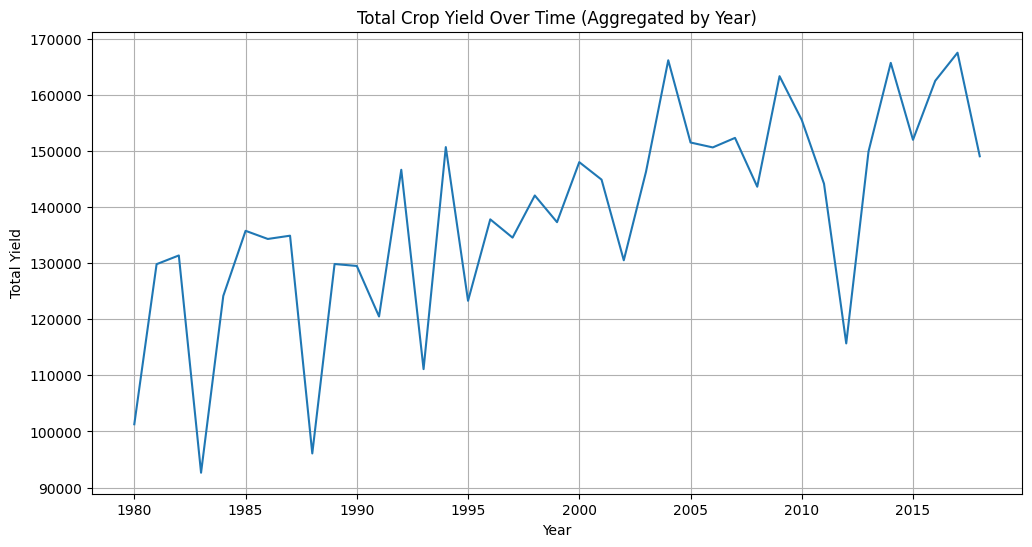

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=yield_by_year, x='year', y='yield')
plt.title('Total Crop Yield Over Time (Aggregated by Year)')
plt.xlabel('Year')
plt.ylabel('Total Yield')
plt.grid(True)

# Save the figure as a PNG file
plt.savefig('yearly_crop_yield_line_chart.png')

plt.show()